In [132]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import sys
sys.path.append("../../../../src/")
import nanonets_utils
import nanonets

plt.style.use(["science","bright","grid"])

from scipy.optimize import curve_fit, lsq_linear, least_squares
from scipy.signal import TransferFunction, lsim
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def sin_func(t, A, f0, phi, B):
    return A*np.sin(2*np.pi*f0*t-phi) + B

def exp_decay(x, a, b, c):
    return a*np.exp(-x/b) + c

def bound_periodic_signal(signal, n, m):
    signs           = np.sign(signal)
    zero_crossings  = np.where((signs[:-1] < 0) & (signs[1:] >= 0))[0]
    start_idx       = zero_crossings[n]
    end_idx         = zero_crossings[m]
    return signal[start_idx:end_idx+1]

In [133]:
N_periods   = 40
U0          = 0.1
amplitudes  = [U0,0.0]
Np          = 9
N_eq_p      = 15
np_idx      = [4+9*i for i in range(9)]

topology_parameter      = {
    "Nx"                : Np,
    "Ny"                : Np,
    "Nz"                : 1,
    "e_pos"             : [[(Np-1)//2,0,0],[(Np-1)//2,Np-1,0]],
    "electrode_type"    : ['constant','floating']
}

folder      = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/ac_input_vs_freq/"
freq_vals   = [0.001,0.002,0.004,0.006,0.008,0.01,0.03,0.06,0.12,0.25,0.5,1.,2.,5.,6.,8.,10.,12.,15.,18.,23.,28.,36.,44.,55.,68.,86.,105.,133.]
time_data   = {}
U0_data     = {}
data        = {}
pot_data    = {}
dt_vals     = {}

for i in range(len(freq_vals)):
    f0                  = freq_vals[i]*1e6      # Convert MHz to Hz
    dt                  = 1/(40 * f0)           # 20 Samples per period
    T_sim               = N_periods/f0
    N_voltages          = int(T_sim/dt)
    frequencies         = [f0,0.0]
    amplitudes          = [0.1,0.0]
    time_steps, volt    = nanonets_utils.sinusoidal_voltages(N_voltages, topology_parameter,
                                                                amplitudes=amplitudes,
                                                                frequencies=frequencies,
                                                                time_step=dt)
    N_volt              = len(time_steps)
    data[f0/1e6]        = pd.read_csv(f"{folder}Nx={Np}_Ny={Np}_Nz=1_Ne=2_{f0/1e6}.csv").iloc[N_eq_p*N_volt//N_periods:,:].reset_index(drop=True)
    pot_data[f0/1e6]    = pd.read_csv(f"{folder}mean_state_Nx={Np}_Ny={Np}_Nz=1_Ne=2_{f0/1e6}.csv").iloc[N_eq_p*N_volt//N_periods:,:].reset_index(drop=True)
    time_data[f0/1e6]   = time_steps[:len(data[f0/1e6])]*1e9
    U0_data[f0/1e6]     = volt[N_eq_p*N_volt//N_periods:-1,0]
    dt_vals[f0/1e6]     = dt

In [116]:
def build_spline_features(x, knots):
    N   = len(x)
    Phi = np.column_stack([np.ones(N), x])
    for c in knots:
        Phi = np.column_stack([Phi, np.maximum(0, x - c)])
    return Phi

def pwl_model(x, knots, theta):
    Phi = build_spline_features(x, knots)
    return Phi.dot(theta)

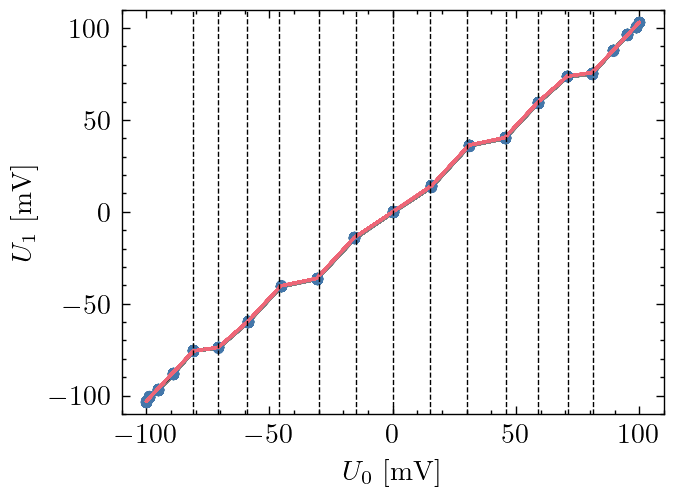

In [117]:
f0  = 0.001
x_v = U0_data[f0]*1000
y_v = data[f0]['Current'].values*1000
y_e = data[f0]['Error'].values*1000

knots       = np.array([-81, -71, -59, -46, -30, -15, 0, 15, 30, 46, 59, 71, 81])
Phi         = build_spline_features(x_v, knots)
theta, *_   = np.linalg.lstsq(Phi, y_v, rcond=None)
y_fit       = pwl_model(x_v, knots, theta)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(x_v,y_v, '.')
ax.plot(x_v,y_fit)
ax.fill_between(x_v,y_v-y_e,y_v+y_e,color='black',alpha=0.5)
ax.vlines(knots, -110, 110, ls='--', color='black', lw=0.5)
ax.set_xlabel("$U_0$ [mV]")
ax.set_ylabel("$U_1$ [mV]")
ax.set_xlim(-110,110)
ax.set_ylim(-110,110)
ax.grid(False)

In [118]:
def f_static(u):
    return pwl_model(u, knots, theta)

In [123]:
def fundamental_freq_amplitude(signal, dt, f0):
    y       = signal - np.mean(signal)
    omega0  = 2*np.pi*f0*1e6
    N       = len(y)
    t       = np.arange(N) * dt
    Y1      = 2.0/N * np.sum(y * np.exp(-1j * omega0 * t))
    return Y1

G_hats  = []
last    = 2
for f0 in freq_vals[:-last]:
    x_v     = data[f0]['E0'].values*1000
    y_v     = data[f0]['Current'].values*1000
    # y_fft   = extract_given_zeros(y_v, 0, 17)
    Y_hat   = fundamental_freq_amplitude(y_v, dt_vals[f0], f0)
    # y_fft   = extract_given_zeros(x_v, 0, 17)
    U_hat   = fundamental_freq_amplitude(x_v, dt_vals[f0], f0)
    G_hat   = Y_hat / U_hat
    G_hats.append(G_hat)

G_hats = np.array(G_hats)
print(G_hats)

[ 1.0025555 -2.13072325e-03j  1.0022878 -4.20490298e-03j
  1.0015962 -8.43982172e-03j  1.00100235-1.27652519e-02j
  1.00044437-1.69622426e-02j  0.99970933-2.11368126e-02j
  0.99598247-5.64825652e-02j  0.99056658-9.44981093e-02j
  0.97700185-1.47020752e-01j  0.94829719-2.21940851e-01j
  0.89202268-3.03414675e-01j  0.80307403-4.11706595e-01j
  0.62768387-5.09447341e-01j  0.27105296-5.29313839e-01j
  0.19479637-5.04368033e-01j  0.08855834-4.30436686e-01j
  0.02099912-3.79456374e-01j -0.02104493-3.21070001e-01j
 -0.05580557-2.47454673e-01j -0.07460784-1.94452552e-01j
 -0.08608208-1.27746609e-01j -0.07850396-7.93189933e-02j
 -0.05313566-3.38493448e-02j -0.03332424-1.42707054e-02j
 -0.01830584-4.24479437e-03j -0.00962236-5.71231884e-04j
 -0.00432655+3.58944976e-04j]


Text(0, 0.5, '$\\varphi$ [°]')

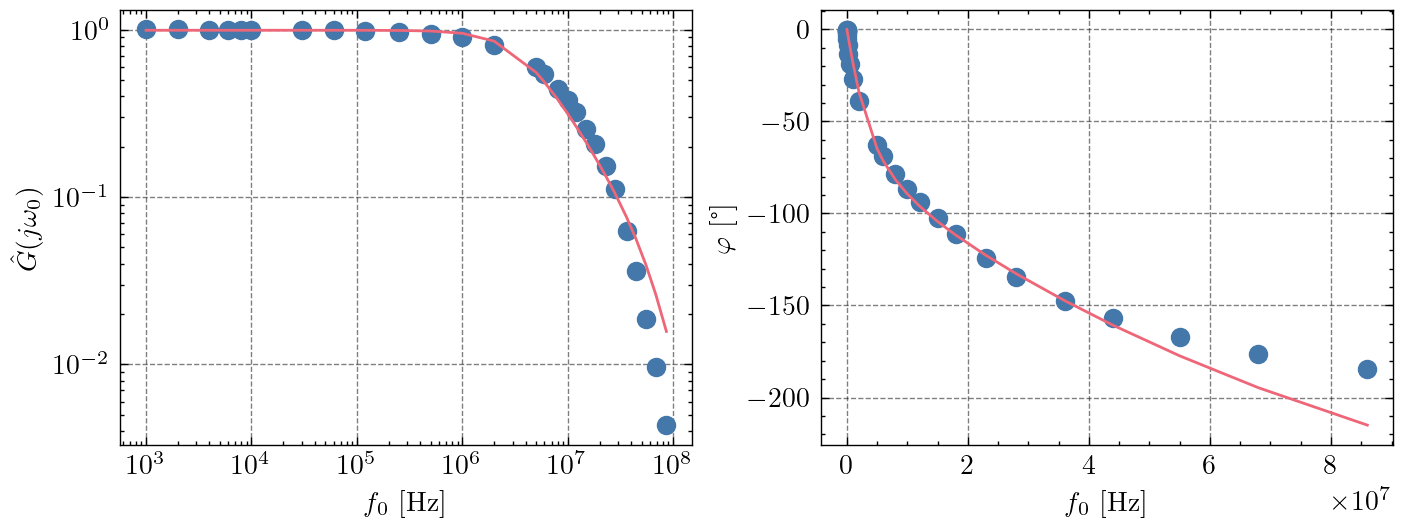

In [135]:
def G_model_complex_zn(omega, K, zeros, poles):
    """
    Compute G(jω) = K * prod_i (1 + jω/zeros[i]) / prod_j (1 + jω/poles[j])
    """
    jw = 1j * omega[:, None]    # shape (len(omega),1)
    zeros = np.atleast_1d(zeros)
    poles = np.atleast_1d(poles)
    num   = np.prod(1 + jw/zeros, axis=1)   if zeros.size   > 0 else 1.0
    denom = np.prod(1 + jw/poles, axis=1)   if poles.size   > 0 else 1.0
    return K * num / denom

def fit_complex_zn(omega, G_meas, n_zeros, n_poles, p0=None):
    """
    Fit K, {z_i}, {p_j} > 0 to measured complex FRF G_meas.
    Uses least-squares on real and imag parts.
    
    Parameters
    ----------
    omega    : array_like
        Angular frequencies (rad/s).
    G_meas   : array_like (complex)
        Measured complex G(jω).
    n_zeros  : int
        Number of numerator zeros.
    n_poles  : int
        Number of denominator poles.
    p0       : array_like, optional
        Initial guess [K, z1..zm, p1..pn].
        If None, zeros/poles are spaced geometrically across omega.
    
    Returns
    -------
    popt : ndarray
        Fitted parameters [K, z1..zm, p1..pn].
    """
    # Initial guess
    if p0 is None:
        K0              = np.abs(G_meas[0])
        w_min, w_max    = omega.min(), omega.max()
        z0              = np.logspace(np.log10(w_min), np.log10(w_max), n_zeros)
        p0s             = np.logspace(np.log10(w_min), np.log10(w_max), n_poles)
        p0              = np.concatenate(([K0], z0, p0s))
    
    def residuals(params):
        K       = params[0]
        zeros   = params[1:1+n_zeros]
        poles   = params[1+n_zeros:]
        G_pred  = G_model_complex_zn(omega, K, zeros, poles)
        return np.concatenate([G_pred.real - G_meas.real,
                               G_pred.imag - G_meas.imag])
    
    # enforce positivity
    lower = np.zeros(1 + n_zeros + n_poles)
    # lower = np.full(1 + n_zeros + n_poles, -np.inf)
    upper = np.full(1 + n_zeros + n_poles, np.inf)
    
    res  = least_squares(residuals, p0, bounds=(lower, upper), max_nfev=10000)
    return res.x, None

f0_MHz  = np.array(freq_vals)[:-last]
f0_Hz   = f0_MHz * 1e6
omega   = 2*np.pi * f0_Hz
n_zeros = 0
n_poles = 4
popt, _ = fit_complex_zn(omega, G_hats, n_zeros=n_zeros, n_poles=n_poles)
K       = popt[0]
zeros   = popt[1:1+n_zeros]
poles   = popt[1+n_zeros:]
G_pred  = G_model_complex_zn(omega, K, zeros, poles)

phase_hats = np.unwrap(np.angle(G_hats))
phase_pred = np.unwrap(np.angle(G_pred))

K, *poles     = popt
den           = np.poly([-p for p in poles])
num           = [K * np.prod(poles)]
G             = TransferFunction(num, den)

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2.0)
ax  = fig.add_subplot(1,2,1)
ax.plot(f0_Hz, np.abs(G_hats), 'o')
ax.plot(f0_Hz, np.abs(G_pred))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("$\hat{G}(j\omega_0)$")
ax.set_xlabel('$f_0$ [Hz]')
ax  = fig.add_subplot(1,2,2)
ax.plot(f0_Hz,np.degrees(phase_hats), 'o')
ax.plot(f0_Hz,np.degrees(phase_pred))
ax.set_xlabel('$f_0$ [Hz]')
ax.set_ylabel('$\\varphi$ [°]')

In [136]:
1e9/np.array(poles)

array([46.8462485 ,  1.69095208,  1.69090625,  1.69109464])

In [126]:
print(freq_vals)

[0.001, 0.002, 0.004, 0.006, 0.008, 0.01, 0.03, 0.06, 0.12, 0.25, 0.5, 1.0, 2.0, 5.0, 6.0, 8.0, 10.0, 12.0, 15.0, 18.0, 23.0, 28.0, 36.0, 44.0, 55.0, 68.0, 86.0, 105.0, 133.0]


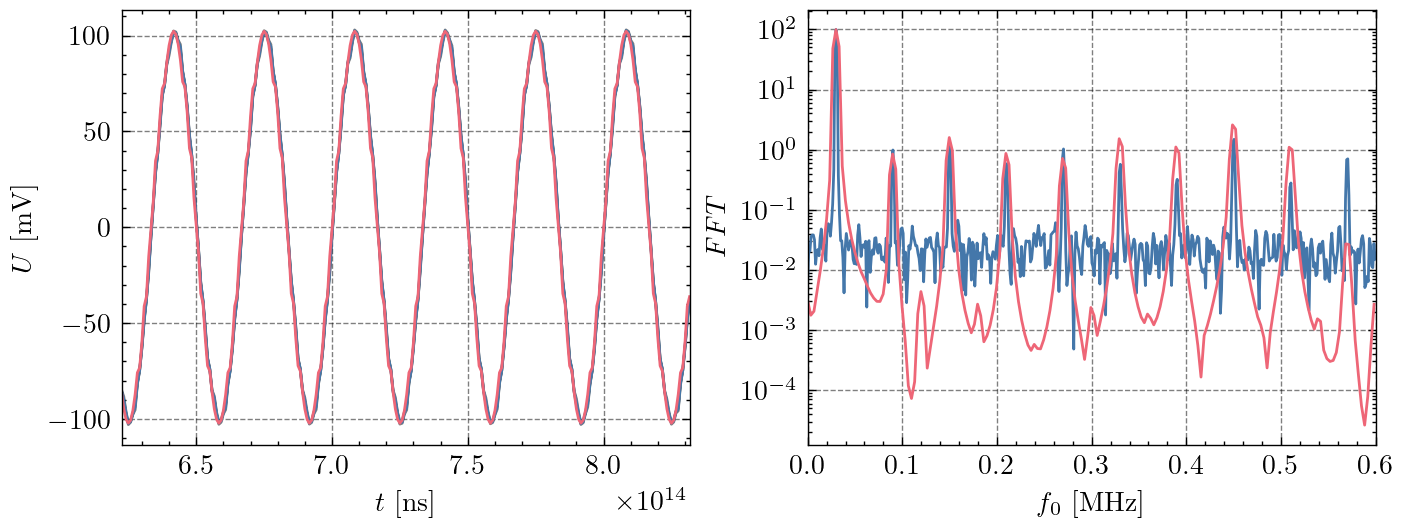

In [131]:
f0          = 0.03
t_v         = time_data[f0]
y_v         = data[f0]['Current'].values*1000
y_e         = data[f0]['Error'].values*1000
w           = f_static(x_v)
_, y_hat, _ = lsim(G, U=w, T=t_v/1e9)

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2.0)

ax  = fig.add_subplot(1,2,1)
ax.plot(t_v*1e9,y_v)
ax.fill_between(t_v*1e9,y_v-y_e,y_v+y_e,color='black',alpha=0.5)
ax.plot(t_v*1e9, y_hat)
ax.set_xlabel("$t$ [ns]")
ax.set_ylabel("$U$ [mV]")
ax.set_xlim(3*t_v[len(t_v)//4]*1e9, np.max(t_v)*1e9)

ax      = fig.add_subplot(1,2,2)
# y_fft   = extract_given_zeros(y_v, 0, 17)
xf, yf  = nanonets_utils.fft(y_v, dt=dt_vals[f0], n_padded=len(y_v)*0, use_hann=True)
ax.plot(xf/1e6, yf, label='$U_0$')
y_fft   = bound_periodic_signal(y_hat, 8, 17)
xf, yf  = nanonets_utils.fft(y_fft, dt=dt_vals[f0], n_padded=len(y_fft)*0, use_hann=True)
ax.plot(xf/1e6, yf, label='$U_1$')
ax.set_xlim(0,20*f0)
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$FFT$")
ax.set_yscale('log')